Author: Pascal, pascal@bayesimpact.org

Date: 2017-11-08

# ROME update from v332 to v333

In November 2017 a new version of the ROME was realeased. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v333. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '332'
NEW_VERSION = '333'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


So we have the same set of files in both versions: good start.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=pd.read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=pd.read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

All files have the same columns as before: still good.

Now let's see for each file if there are more or less rows.

In [5]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(-diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(same_row_count_files, len(rome_data)))

109/30706 values added in unix_coherence_item_v333_utf8.csv
15/11646 values added in unix_cr_gd_dp_appellations_v333_utf8.csv
133/16308 values added in unix_item_arborescence_v333_utf8.csv
57/13381 values added in unix_item_v333_utf8.csv
124/42228 values added in unix_liens_rome_referentiels_v333_utf8.csv
34/7396 values added in unix_referentiel_activite_riasec_v333_utf8.csv
54/9186 values removed in unix_referentiel_activite_v333_utf8.csv
15/10990 values added in unix_referentiel_appellation_v333_utf8.csv
33/4980 values removed in unix_referentiel_competence_v333_utf8.csv
12/21 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in `referentiel_appellation`, `item`, and `liens_rome_referentiels`, so let's see more precisely.

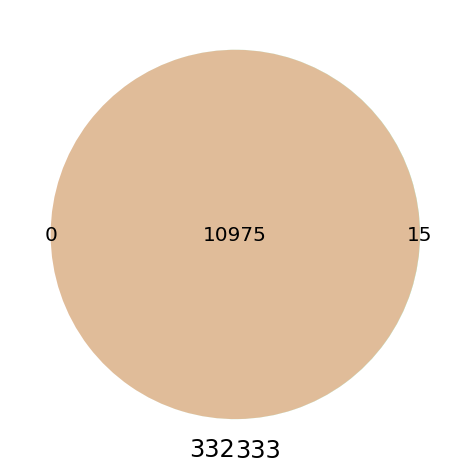

In [6]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 15 new jobs added. Let's take a look (only showing interesting fields):

In [7]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
2421,126547,Game master jeux online,E1101
2422,126548,Producer chef de projet jeux vidéo,E1104
2423,126549,UX - user experience designer,E1205
2425,126550,UI - user interface designer,E1205
2426,126551,Musher guide de randonnée en traîneau,G1201
2427,126552,Entraîneur / Entraîneuse d''équipe sportive de football,G1204
2428,126553,Entraîneur / Entraîneuse de sportifs de haut niveau de football,G1204
2429,126554,Entraîneur sportif / Entraîneuse sportive de football,G1204
2430,126555,Technicien / Technicienne d''installation de systèmes d''irrigation,K2301
2431,126556,Technicien / Technicienne de maintenance de systèmes d''irrigation,K2301


They mostly seem related to the digital industry, e.g. we finally have a job for John, our UX Designer. But there are also few others.

OK, let's check at the changes in items:

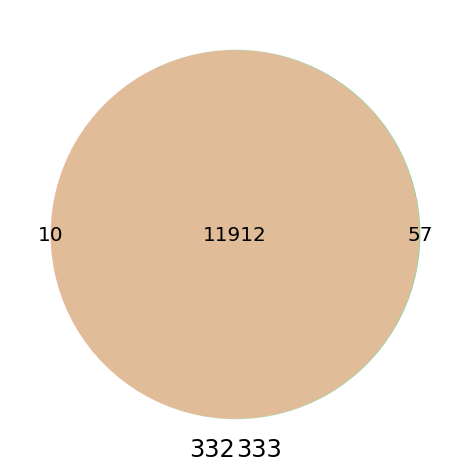

In [8]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

As anticipated it is a very minor change (hard to see it visually): some items are now obsolete and new ones have been created. Let's have a look.

In [9]:
items.old[items.old.code_ogr.isin(obsolete_items)].tail()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
8294,121553,Contractualiser une prestation avec un client,2,6,NaN,NaN,NaN
8295,121553,Contractualiser une prestation avec un client,2,9,NaN,NaN,NaN
8472,121772,Etablir les modalités d''une prestation avec le client,2,9,NaN,NaN,NaN
8751,122123,Poser des matériaux d''isolation,2,6,NaN,NaN,NaN
8752,122123,Poser des matériaux d''isolation,2,9,NaN,NaN,NaN


In [10]:
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
5916,115701,Mener une campagne d''e-mailing,2,9,NaN,NaN,NaN
5929,115832,Knowledge Management,1,10,NaN,NaN,NaN
5951,115923,Insights marketing,1,10,NaN,NaN,NaN
5952,115924,Management de l''économie numérique,1,10,NaN,NaN,NaN
6022,116279,Mettre en place des solutions de suivi (tracking) pour analyser le trafic d''un site et les comportements de navigation des visiteurs,2,9,NaN,NaN,NaN


Those entries look legitimate.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [11]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added    48
Name: _diff, dtype: int64

So in addition to the added and remove items, there are 48 fixes. Let's have a look:

In [12]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').old.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
links_merged.dropna().head(10)

,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
30577,C1401,121910,right_only,added,Gestion en banque et assurance,Mener une action commerciale
30578,E1101,115743,right_only,added,Animation de site multimédia,E-commerce
30579,E1107,121431,right_only,added,Organisation d''évènementiel,Contractualiser une prestation
30580,E1104,104155,right_only,added,Conception de contenus multimédias,Gestion financière
30581,E1104,118319,right_only,added,Conception de contenus multimédias,Dispositifs de financement culturel
30582,E1104,119109,right_only,added,Conception de contenus multimédias,"Définir les moyens humains, matériels et financiers d''un projet"
30583,E1104,119659,right_only,added,Conception de contenus multimédias,Sélectionner un projet en cohérence avec une politique artistique
30584,E1104,121661,right_only,added,Conception de contenus multimédias,Négocier des partenariats
30585,E1104,124059,right_only,added,Conception de contenus multimédias,Établir un dossier de demande de financement
30586,E1104,124097,right_only,added,Conception de contenus multimédias,Promouvoir un projet


Those fixes make sense (not sure why they were not done before, but let's not complain: it is fixed now).

# Conclusion

The new version of ROME, v333, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/front/common/tools/load_file.jspz?galleryId=75498&galleryTitle=ROME+Actualisation+du+23+octobre+2017). The transition should be transparent with a very small advantage over the old version.